## Run radlite to create an image and/or spectrum based on the output of make_model.ipynb
### 12/12/23 jpw


### Includes a super-class to customize velocity field
### and plotting routines to visualize the density, temperature, and velocity structure
### 3/5/24 jpw

In [1]:
# choose what you want to do here and then "Run All"
# if image is False, you get a spectrum!
make_image = True
make_plots = True

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
%matplotlib inline

In [3]:
#Import Python-RADLite package
sys.path.append("/Users/jpw/py/radlite_for_radmc3d")
import radlite as RDL

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.


In [4]:
# create a super class to allow for more flexible velocity structure
class CustomModel(RDL.RadliteModel):
    def __init__(self, infilename, hitranfilename, radmcfilepath):
        super().__init__(infilename, hitranfilename, radmcfilepath)
        
    def _calc_velocity(self):
        # this function supersedes the one in radlite which only does Keplerian motion

        # radlite spherical coordinates
        r = self.get_attr("radius") #Radii
        rlen = len(r)
        theta = self.get_attr("theta") #Co-lattiude in Dullemond parlance (radians)
        tlen = len(theta)//2 #Only take the top half since we assume symmetry
        theta = theta[0:tlen]

        mstar = self.get_attr("starinfo")["mstar"] #Stellar mass
        rstar = self.get_attr("starinfo")["rstar"] #Stellar radius
        if self.get_attr("verbose"): #Verbal output, if so desired
            print("Calculating velocity field components...")
            print("Used starinfo.inp file for mstar and rstar...")

        G0 = 6.67259e-8
        au = 1.49597870e13

        # -------------------------------------- #
        # choose which velocity pattern you want
        add_wind = True
        # -------------------------------------- #

        if add_wind:
            if self.get_attr("verbose"):
                print("Kurosawa wind model")

            # Edit these parameters if desired
            D = 1 * au            # collimation distance
            Rs = 0.5 * au         # wind scale length
            v_terminal = 100      # terminal velocity in km/s
            v_terminal *= 1e5     # cm/s
            beta = 2
            cs = 6e4              # sound speed in km/s at 1000 K

            # used for pressure scale height (from parameterized_disk.py)
            hrdisk = 0.1          # ratio of the pressure scale height over radius at hrpivot
            hrpivot = 100 * au    # reference radius at which Hp/R is taken
            plh = 1/7             # radial power law index

            # use Kurosawa notation where (w,z) are cylindrical coordinates
            rr, tt = np.meshgrid(r, theta)
            ww = rr * np.sin(tt)
            zz = rr * np.cos(tt)
            wcross = ww*D/(zz+D)
            S = np.sqrt(wcross**2 + D**2)
            l = np.sqrt((ww-wcross)**2 + zz**2)
            vp = cs + (v_terminal-cs) * (1 - Rs/(l+Rs))**beta
            ksi = np.arcsin(D * np.sin(np.pi-tt) / (S+l))

            # zero out the wind below some number of pressure scale heights (where the temperature changes)
            # unfortunately this is hardwired in using parameters from the radmc model setup
            # so change if necessary
            Hp = hrdisk * (ww/hrpivot)**plh
            no_wind = np.where(zz < 2*Hp*ww)[0]
            vp[no_wind] = 0

            vel_radial = vp * np.cos(ksi)
            vel_theta = vp * np.sin(ksi)
            vel_phi = np.sqrt(G0*mstar/rr) * wcross/ww
        else:
            # pure Keplerian rotation; copied over from original radlite code
            if self.get_attr("verbose"):
                print("Keplerian rotation")
            rexparr = np.resize(r, (tlen, rlen)) #Radii, expended to 2D
            vel_radial = np.zeros(shape=(tlen, rlen))
            vel_theta = np.zeros(shape=(tlen, rlen))
            vel_phi = np.sqrt(G0*mstar/rexparr)

        ##Below Section: RECORD velocity components and EXIT
        self._set_attr(attrname="velocity_theta", attrval=vel_theta,
                            attrunit=r"cm s$^{-1}$")
        self._set_attr(attrname="velocity_radial", attrval=vel_radial,
                            attrunit=r"cm s$^{-1}$")
        self._set_attr(attrname="velocity_phi", attrval=vel_phi,
                            attrunit=r"cm s$^{-1}$")
        if self.get_attr("verbose"): #Verbal output, if so desired
            print("Done calculating velocity components!\n")
        return


In [5]:
if make_image:
    infilename = "model_image.json"
else:
    infilename = "model_spectrum.json"
    inspecfilename = "spectrum.json"

radmcfilepath = "./"
hitranfilename = "../../molecule_files/data_hitran.json"
myMod = CustomModel(infilename=infilename, hitranfilename=hitranfilename, radmcfilepath=radmcfilepath)

--------------------------------------------------
Welcome to RADLite Version 1.3.0!

RADLite Version 1.2 (in IDL) was written by:
Klaus Pontoppidan (pontoppi@stsci.edu)
Kees Dullemond
Alex Lockwood
Rowin Meijerink

RADLite Version 1.3.0 (in Python) was written by:
Jamila Pegues (jamila.pegues@cfa.harvard.edu)
Klaus Pontoppidan (pontoppi@stsci.edu)

unofficial changes to work with radmc3dPy
Jonathan Williams (jw@hawaii.edu)
--------------------------------------------------



----------
Now preparing all RADLite input files...

Will prepare a rectangular-formatted image cube...

Writing RADLite input files...

Calculating abundance...
Setting a constant abundance...
Done calculating abundance!

Calculating gas density from dust density...
Done calculating gas density!

Calculating gas temperature...
Assuming gas temperature = dust temperature...
Done calculating gas temperature!

Calculating turbulence...
Using first dust component temperature to determine turbulent velocities...
Done

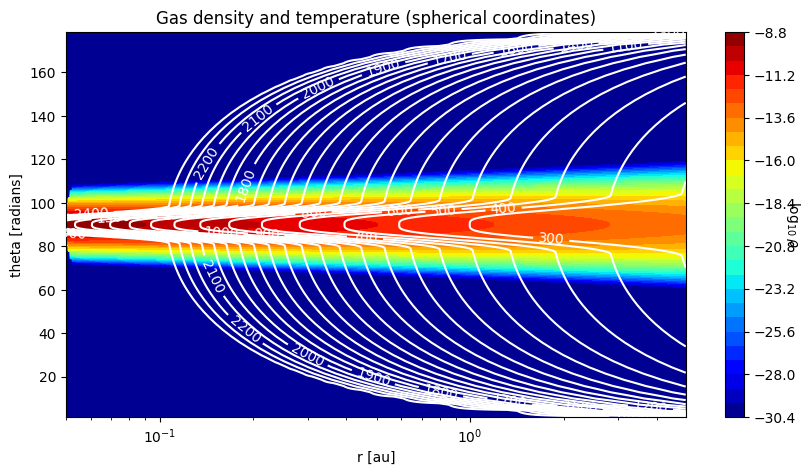

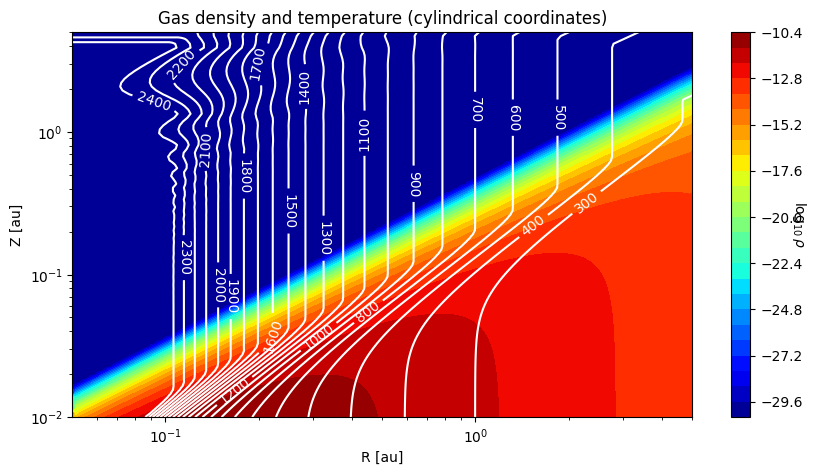

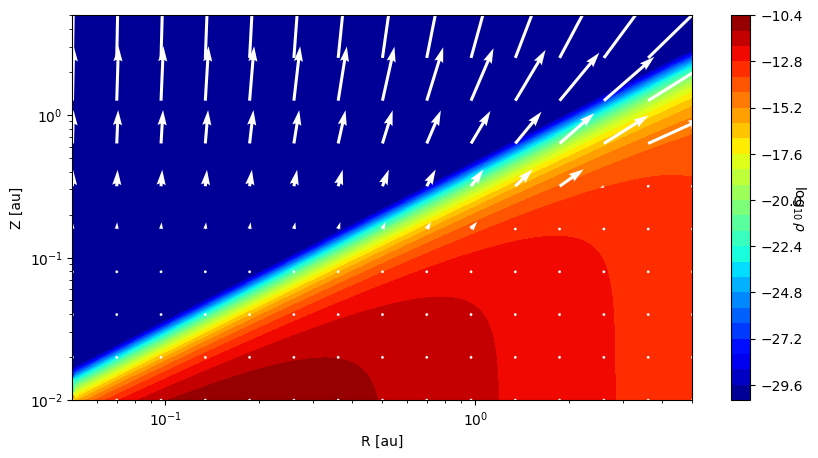

In [6]:
if make_plots:
    figsize = (10, 5)
    xlog = True
    xscaler = 6.6846E-14
    xunit = "AU"
    yscaler = 180.0/3.14159
    yunit = "deg"
    levels = 100
    axisfontsize = 14
    titlefontsize = 16
    tickfontsize = 14

    title = "Gas Density (Spherical coordinates)"
    myMod.plot_attr("gasdensity", figsize=figsize, zlog=True,
                    xlog=xlog, xscaler=xscaler, xunit=xunit,
                    yscaler=yscaler, yunit=yunit, levels=levels,
                    cmap='jet', title=title, axisfontsize=axisfontsize,
                    titlefontsize=titlefontsize, tickfontsize=tickfontsize,
                    dosave=True, savename='gas_density_spherical.png')

    title = "Gas Temperature (Spherical coordinates)"
    myMod.plot_attr("gastemperature", figsize=figsize, xlog=xlog, xscaler=xscaler, xunit=xunit,
                    yscaler=yscaler, yunit=yunit, levels=levels,
                    cmap='jet', title=title, axisfontsize=axisfontsize,
                    titlefontsize=titlefontsize, tickfontsize=tickfontsize,
                    dosave=True, savename='gas_temperature_spherical.png')

    # regrid from radlite spherical coordinates (r,theta) into (R,Z) cylindrical coordinates
    r = myMod.get_attr("radius") / 1.5e13
    theta = myMod.get_attr("theta")
    nr = r.size
    nt = theta.size

    logdens = np.log10(myMod.get_attr("gasdensity"))
    Tgas = myMod.get_attr("gastemperature")
    dens_spline = RectBivariateSpline(theta, r, logdens)
    Tgas_spline = RectBivariateSpline(theta, r, Tgas)

    nR = 200
    R = np.logspace(-1.3, 0.7, nR)
    nZ = 100
    Z = np.logspace(-2, 0.7, nZ)

    logdens_RZ = np.zeros((nZ, nR))
    Tgas_RZ = np.zeros((nZ, nR))
    for j in range(nR):
        for i in range(nZ):
            r1 = np.sqrt(R[j]**2 + Z[i]**2)
            t1 = np.arctan(R[j]/Z[i])
            logdens_RZ[i,j] = dens_spline(t1, r1)
            Tgas_RZ[i,j] = Tgas_spline(t1, r1)
    
    Tmax = np.max(Tgas_RZ)
    nlevs = int(Tmax/100) - 4
    Tlevs = (3 + np.arange(nlevs)) * 100

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    c1 = ax.contourf(r, np.degrees(theta), logdens, 30, cmap='jet')
    ax.set_xlabel('r [au]')
    ax.set_ylabel(r'theta [radians]')
    ax.set_xscale('log')
    ax.set_title('Gas density and temperature (spherical coordinates)')
    cb = plt.colorbar(c1)
    cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)
    c2 = ax.contour(r, np.degrees(theta), Tgas, Tlevs,  colors='w', linestyles='solid')
    ax.clabel(c2, inline=1, fontsize=10)
    plt.savefig('gas_density_temperature_spherical.png')

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    c1 = ax.contourf(R, Z, logdens_RZ, 30, cmap='jet')
    ax.set_xlabel('R [au]')
    ax.set_ylabel(r'Z [au]')
    ax.set_title('Gas density and temperature (cylindrical coordinates)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    cb = plt.colorbar(c1)
    cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)
    c2 = ax.contour(R, Z, Tgas_RZ, Tlevs,  colors='w', linestyles='solid')
    ax.clabel(c2, inline=1, fontsize=10)
    #----------------------------------------------------------
    # calculate tau=1 surface at 0.5 microns
    # this is from midplane vertically up so in cyleindrical coordinates
    # BUT this does not agree with the getTau module using the new format so do not use
    # (also need to uncomment a line in radmc.py to make it work so a bit untested perhaps?)
    #import radmc
    #RM = radmc.radmc_model('./')
    #R_thick, Z_thick = RM.surface_at_tau(1, wave=0.5)
    #R_thick /= 1.5e13
    #Z_thick /= 1.5e13
    #ax.plot(R_thick, Z_thick,  color='black', ls='solid', lw=5, alpha=0.3)
    #----------------------------------------------------------
    plt.savefig('gas_density_temperature_cylindrical.png')

    # velocity field
    nt2 = theta.size // 2
    theta2 = theta[0:nt2]
    vrad = myMod.get_attr("velocity_radial") / 1e5
    vtheta = myMod.get_attr("velocity_theta") / 1e5
    vphi = myMod.get_attr("velocity_phi") / 1e5

    if np.max(vrad)-np.min(vrad) > 0 or np.max(vtheta)-np.min(vtheta) > 0:
        rr, tt2 = np.meshgrid(r, theta2)
        vR = vrad*np.sin(tt2) - vtheta*np.cos(tt2)
        vZ = vrad*np.cos(tt2) + vtheta*np.sin(tt2)
        vR_spline = RectBivariateSpline(theta2, r, vR)
        vZ_spline = RectBivariateSpline(theta2, r, vZ)
        vphi_spline = RectBivariateSpline(theta2, r, vphi)
        # sparse grid because otherwise the quiver plot is too crowded
        nR = 15
        Rv = np.logspace(-1.3, 0.7, nR)
        nZ = 10
        Zv = np.logspace(-2, 0.7, nZ)
        vrad_RZ = np.zeros((nZ, nR))
        vtheta_RZ = np.zeros((nZ, nR))
        vR_RZ = np.zeros((nZ, nR))
        vZ_RZ = np.zeros((nZ, nR))
        vphi_RZ = np.zeros((nZ, nR))
        for j in range(nR):
            for i in range(nZ):
                r1 = np.sqrt(Rv[j]**2 + Zv[i]**2)
                t1 = np.arctan(Rv[j]/Zv[i])
                vR_RZ[i,j] = vR_spline(t1, r1)
                vZ_RZ[i,j] = vZ_spline(t1, r1)
                vphi_RZ[i,j] = vphi_spline(t1, r1)
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        c1 = ax.contourf(R, Z, logdens_RZ, 30, cmap='jet')
        ax.set_xlabel('R [au]')
        ax.set_ylabel(r'Z [au]')
        ax.set_xscale('log')
        ax.set_yscale('log')
        cb = plt.colorbar(c1)
        cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)
        ax.quiver(Rv, Zv, vR_RZ, vZ_RZ, color='white')
        plt.savefig('gas_non_azimuthal_velocity.png')


## Running RADLite
### (this works for both image and spectrum and will take a minute or two...)

In [7]:
#Run RADLite
myMod.run_radlite()

Attempting to create run directory rundir_image...
rundir_image already exists. Will overwrite files within.
All input files and final data will be saved to the following folder in the current directory: rundir_image
Running RADLite on 7 core(s)...
Generating working directory for cores called: ./rundir_image/workingdir
All core outputs will be stored in: ./rundir_image/outputdir
Replacing previous ./rundir_image/outputdir...
Prepping 0th core...
Starting 0th core in ./rundir_image/workingdir/workingdir_cpu0/...


mkdir: rundir_image: File exists
mkdir: ./rundir_image/outputdir: File exists


0th core has started working...
Prepping 1th core...
Starting 1th core in ./rundir_image/workingdir/workingdir_cpu1/...
1th core has started working...
1th core does not have any lines to process.  Exiting...
(Function _run_core took 5.49e-03s.)
Prepping 2th core...
Starting 2th core in ./rundir_image/workingdir/workingdir_cpu2/...
2th core has started working...
2th core does not have any lines to process.  Exiting...
(Function _run_core took 4.98e-03s.)
Prepping 3th core...
Starting 3th core in ./rundir_image/workingdir/workingdir_cpu3/...
3th core has started working...
3th core does not have any lines to process.  Exiting...
(Function _run_core took 5.52e-03s.)
Prepping 4th core...
Starting 4th core in ./rundir_image/workingdir/workingdir_cpu4/...
4th core has started working...
4th core does not have any lines to process.  Exiting...
(Function _run_core took 5.48e-03s.)
Prepping 5th core...
Starting 5th core in ./rundir_image/workingdir/workingdir_cpu5/...
5th core has started wor

## Write out image or spectrum as a fits file
Note hat in jupyter notebooks, gen_spec produces an error ("THE_PROCESS_HAS_FORKED...") which I cannot seem to avoid but it appears harmless... (and it doesn't happen in vscode)

In [8]:
# set filename and distance if you don't want the defaults (first molecular dat file and 140pc)
if make_image:
    import image2fits
    image2fits.read_and_write()
else:
    mySpec = RDL.RadliteSpectrum(infilename=inspecfilename)
    mySpec.gen_spec()

    fig = plt.figure(figsize=(10, 8))
    yscaler = 1000                     # Scale the y-axes from Jy to mJy
    mySpec.plot_spec("spectrum",
                 fig=fig,
                 dopart=True,
                 linecolor="blue", linewidth=2, alpha=0.7,
                 yscaler=yscaler,
                 leglabel="Full Spectrum")
    mySpec.plot_spec("emission",
                 fig=fig,
                 dopart=True,
                 linecolor="lightblue", linewidth=2, alpha=0.6, linestyle="-",
                 yscaler=yscaler,
                 leglabel="Emission")
    mySpec.plot_spec("continuum",
                 fig=fig,
                 dopart=False,
                 linecolor="gray", linewidth=3, alpha=0.8, linestyle="--",
                 yscaler=yscaler,
                 ylabel=r"$^{12}$CO Spectral Data", yunit="mJy",
                 dolegend=True, legloc="upper right",
                 leglabel="Continuum",
                 axisfontsize=20, titlefontsize=22,
                 tickfontsize=18, legfontsize=20,
                 title="Model spectrum components")
    fitsname = "radlite_spectrum.fits"
    mySpec.write_fits(fitsname, overwrite=True)